In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
import time

In [2]:
#Viral dynamics parameter
hour = 24
CL_V = 2.3/hour
lambdaT = 2e9/hour
deltaT = 0.02/hour
deltaT1 = 0.02/hour
deltaT2 = 1/hour
deltaPIC = 0.35/hour
k = 0.35/hour
beta = 8e-12/hour
NThat = 1000/hour
NT = 670/hour  #NT = 0.67*NThat
NTdiff = 330/hour
Tu = lambdaT/deltaT

In [5]:
def eta(D):    
    return D/(IC50 + D)

def betaT(D):
    return beta*(1-eta(D))
                
def CLT(D):
    return (1 + eta(D))*beta

def A(X,D,t):
    a = np.array([(CL_V + CLT(D)*Tu)*X[0],(deltaPIC+deltaT1)*X[1],deltaT2*X[2],
                  (1-eta(D))*beta*Tu*X[0],k*X[1],NT*X[2]])
    return a

def PE(X,D): #extinction probability for RTIs
    R = (1-eta(D))*beta*Tu/((1-eta(D))*beta*Tu+CL_V + CLT(D)*Tu)
    R *= k/(deltaPIC+deltaT1+k)
    R *= NT/deltaT2
    
    testV = (1-eta(D))*beta*Tu/((1-eta(D))*beta*Tu+ CL_V + CLT(D)*Tu)
    testV *= k/(deltaPIC+deltaT1+k)
    resV = min(1,1-testV*(1-1/R))
    resT1 = min(1,1-k/(deltaPIC+deltaT1+k)*(1-1/R))
    resT2 = min(1,1/R)
    logres = X[0]*np.log(resV) + X[1]*np.log(resT1) + X[2]*np.log(resT2)
    return np.exp(logres)

def choose(vec,a0tau2):
    i = 0
    while(i < len(vec)):
        if np.sum(vec[:i]) < a0tau2 <= np.sum(vec[:i+1]):
            return i
        i+=1
    return i

def Extrande(Y,D,v,t0,tfinal):
    count = 0; maxcount = 50000
    jj = -1
    t = t0
    while (t < tfinal) & (count < maxcount):
        count += 1
        if count >= maxcount:
            jj = 4
            #print('limit for counts exceeded, time = ',t)
        # Determine upper bound for the sum of the reaction propensities
        bx = A(Y,0,t)
        B = np.sum(bx)
        r1 = random.uniform(0,1)
        tau = 1/B*np.log(1/r1)
        t = t + tau
        if t  >= tfinal:
            jj = 3
            break 
        ax = A(Y,D,t)
        a0 = np.sum(ax)
        r2 = random.uniform(0,1)
        if a0 > B * r2: # A reaction fires changing the state
            # Choose the reaction
            j = choose(ax,B*r2) # using Hee's function 
            if (j == 3) | (j == 4): # 3,4 instead of R4, R5
                r3 = random.uniform(0,1)
                br = False
                if (j == 3) & (r3 <= 1.25e-4): br = True
                if (j == 4) & (r3 <= 8e-6): br = True
                if br:
                    #print('long lived latently infected cell, count = ',count)
                    jj = 2
                    break                    
            Y += v[:,j] 
            #print('t = ',t,' Y = ',Y,' D = ',D,' count = ',count)
            if (Y[0] == 0) & (Y[1] == 0) & (Y[2] == 0): 
                jj = 0
                T.append(0); E.append(1)
                #print('extinction')
                #print('count = ',count)
                break            
            
            else:
                if PE(Y,D) < epsilon:
                    #print('Infection event')
                    jj = 1
                    T.append(1); E.append(0)
                    break
                # Compute the extinction probability & and drug concentration Dmax
            
            
        #else: # The trajectory at time t is within the extinction simplex
            #print('rejection step! count = ',count)
    
    return jj

def superExtrande(D):
    global T, E
    T = []; E = []
    # Initialization
    Y = [1,0,0]
    t0 = 0; tfinal = 24

    res = [0,0,0,0,0,0] #each position specifies an event of Extrande
    for ii in range(n):
        jj = Extrande(Y,D,v,t0,tfinal) #jj integer, specifies the calculated event
        res[jj+1] += 1 #offset 1
    return T, E

#Survival analysis
def confInt(T,E):
    kmf = KaplanMeierFitter()
    # T and E are filled in the Extrande function.
    kmf.fit(T, event_observed=E)
    middle = kmf.survival_function_['KM_estimate'][0]
    lower = kmf.confidence_interval_['KM_estimate_lower_0.95'][0]
    upper = kmf.confidence_interval_['KM_estimate_upper_0.95'][0]
    return middle, lower, upper

def phi(D):
    mList, lList, uList = [], [], []
    for ii in range(nn):
        T,E = superExtrande(D)
        mid, low, up = confInt(T,E)
        mList.append(mid); lList.append(low); uList.append(up)
    phimid = max(0,1 - np.mean(mList)/mid0)
    phiup = max(0,1 - np.mean(lList)/up0)
    philow = max(0,1 - np.mean(uList)/low0)
    return phimid, philow, phiup

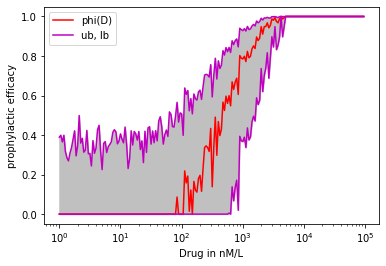

In [4]:
# stoichiometric matrix, vij
Ncols = 6; Nrows = 3
v = np.zeros((Nrows,Ncols),dtype = int)
v[0][0] = -1; v[0][3] = -1; v[0][5] = 1
v[1][1] = -1; v[1][3] = 1; v[1][4] = -1
v[2][2] = -1; v[2][4] = 1; v[2][5] = 0
    
    
epsilon = 0.0001 # needed in Extrande for identifying infection events    
Y0 = [1,0,0] # only one virus is to be considered

n = 1000 # number of Extrande runs
nn = 5 # nn times superExtrande for each D

#Estimated PD parameter
IC50 = 458 #nM/L

# determination of values for D = 0
T0, E0 = superExtrande(0)
mid0, low0, up0 = confInt(T0,E0)

DList = []
phiListmid, phiListlow, phiListup = [], [], []
for i in range(200):
    logd = 0.025*i
    DList.append(10**logd)
    mi, lo, up = phi(10**logd)
    phiListmid.append(mi)
    phiListlow.append(lo)
    phiListup.append(up)

# plot results
plt.xscale('log')    
plt.plot(DList,phiListmid,'r-',label='phi(D)')
plt.plot(DList,phiListlow,'m-',label='ub, lb')
plt.plot(DList,phiListup,'m-',)
plt.fill_between(DList,phiListlow,phiListmid,color = 'silver')
plt.fill_between(DList,phiListmid,phiListup,color = 'silver')
plt.ylabel('prophylactic efficacy')
plt.xlabel('Drug in nM/L')
plt.legend(loc='best')
#plt.title('Islatravir IC50 = ' + str(IC50))
plt.show()